In [114]:
import os
import sys
import warnings
from pathlib import Path


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import anndata as ad
from tqdm import tqdm

import scgp
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%load_ext jupyter_spaces

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_spaces extension is already loaded. To reload it, use:
  %reload_ext jupyter_spaces


# Preprocess and format data

In [2]:
%%space lilab_tma
project_dir = "/mnt/radonc-li02/public/he_codex/raw/tma/project/"
adata_dir = os.path.join(project_dir,"external_data","adata")
json_dir = os.path.join(project_dir,"external_data","stardist_qupath_detection_withcluster")

In [189]:
%%space lilab_tma
def get_ordered_markers():
    markers_dict = {
        "Epi":["Pan-CK","E-cadherin","EpCAM"],
        "TCD8":["CD3e","CD8","Granzyme B"],
        "TCD4":["CD3e","CD4"],
        "Treg":["CD3e","FOXP3"],
        "NK":["Granzyme B"],
        "Neutrophil":["MPO","CD66b"],
         "CAF":["FAP"],
        "SMC":["aSMA"],
        "B cell":["CD20"],
        "Plasma":["CD138"],
        "EC":["CD31"],
        "Mono":["CD14"],
        "M1":["CD68"],
        "M2":["CD163"],
        "DC":["CD11c","HLA-DR"]
    }
    all_markers = list()
    for m in markers_dict.values():
        all_markers += [i for i in m if i not in all_markers]
    return all_markers
all_markers_ordered = get_ordered_markers()

In [190]:
%%space lilab_tma
# output dirs
expression_dir = os.path.join(project_dir, "external_data", "expression_df")
os.makedirs(expression_dir,exist_ok=True)
for adata_fp in tqdm(list(Path(adata_dir).glob("*.h5ad"))):
    adata = ad.read_h5ad(adata_fp)
    adata.X[np.isnan(adata.X)]=0
    adata = adata[:,all_markers_ordered]
    df = pd.DataFrame(adata.X, index = adata.obs["cell_id"], columns = adata.var.index)
    df.index.name="CELL_ID"
    df.to_csv(Path(expression_dir)/(adata_fp.stem+".csv"))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281/281 [00:30<00:00,  9.31it/s]


In [191]:
%%space lilab_tma
sys.path.append("/mnt/radonc-li02/private/lzx325/virtual-biomarking/tools/preprocess/he_codex/0_registeration/")
from geometry_tools import QuPathGeojson

In [192]:
import numpy as np
from shapely.geometry import Polygon
from typing import Tuple

def polygon_and_centroid(coords: np.ndarray) -> Tuple[Polygon, Tuple[float, float]]:
    """
    Build a Shapely Polygon from a NumPy array of coordinates and compute its centroid.

    Parameters
    ----------
    coords : np.ndarray
        Array of shape (N, 2) representing (x, y) coordinates in order.
        The ring may or may not be closed (first point equals last point).

    Returns
    -------
    poly : shapely.geometry.Polygon
        The constructed polygon (with a closed exterior ring).
    centroid_xy : (float, float)
        The centroid coordinates as (x, y).

    Raises
    ------
    ValueError
        If coords has the wrong shape, too few points, or forms an invalid polygon.
    """
    # Basic shape checks
    if not isinstance(coords, np.ndarray):
        raise ValueError("coords must be a NumPy array.")
    if coords.ndim != 2 or coords.shape[1] != 2:
        raise ValueError("coords must have shape (N, 2).")
    if coords.shape[0] < 3:
        raise ValueError("At least 3 points are required to form a polygon.")

    # Ensure closure (allow slight float wiggle with allclose)
    is_closed = np.allclose(coords[0], coords[-1])
    ring = coords if is_closed else np.vstack([coords, coords[0]])

    poly = Polygon(ring)

    # Validate polygon (self-intersections, degeneracy, etc.)
    if poly.is_empty or not poly.is_valid:
        # If you prefer auto-fixing, you could use: poly = poly.buffer(0)
        # but it's safer to fail loudly unless you explicitly want that behavior.
        raise ValueError("The input coordinates do not form a valid polygon.")

    c = poly.centroid
    return poly, (c.x, c.y)

In [6]:
%%space lilab_tma
from collections import defaultdict
centroid_dir = os.path.join(project_dir, "external_data", "centroid")
os.makedirs(centroid_dir,exist_ok=True)
for json_fp in tqdm(list(Path(json_dir).glob("*.json"))):
    qpjson = QuPathGeojson()
    qpjson.read_geojson(json_fp)
    data_dict=defaultdict(list)
    for cell_index in qpjson.cell_id.keys():
        data_dict["CELL_ID"].append(qpjson.cell_id[cell_index])
        _, (X,Y) = polygon_and_centroid(qpjson.cell_polygon[cell_index])
        data_dict["X"].append(X)
        data_dict["Y"].append(Y)
    data_df = pd.DataFrame(data_dict)
    data_df.to_csv(os.path.join(centroid_dir,json_fp.stem + ".csv"),index=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281/281 [01:46<00:00,  2.65it/s]


In [193]:
%%space lilab_tma
# selection of core samples
np.random.seed(0)
all_samples = [fp.stem for fp in Path(adata_dir).glob("*.h5ad")]
# core_samples = sorted(np.random.choice(all_samples,50,replace=False).tolist())
core_samples = sorted(all_samples)
with open(os.path.join(project_dir,"external_data","scgp_core_samples.txt"),'w') as f:
    print("\n".join(core_samples),file = f)

In [194]:
%%space lilab_tma
with open(os.path.join(project_dir,"external_data","scgp_core_samples.txt")) as f:
    core_samples = [line.rstrip() for line in f]

In [195]:
%%space lilab_tma
regions = core_samples
ref_objs = list()
for sample_id in regions:
    cell_seg_df = scgp.load_cell_coords(os.path.join(project_dir,"external_data","centroid",f'{sample_id}.HE.csv'))
    biomarker_expression_df = scgp.load_cell_biomarker_expression(os.path.join(project_dir,"external_data","expression_df",f'{sample_id}.csv'))
    assert not np.any(np.isnan(biomarker_expression_df.iloc[:,1:])), sample_id
    obj = scgp.construct_object(
        sample_id, cell_seg_df, biomarker_expression_df,
        index_col='CELL_ID', mode='anndata')  # mode can be 'emobject' or 'anndata', both will work for the following steps
    ref_objs.append(obj)

In [205]:
%%space lilab_tma
ref_scgp_partitions, (ref_features, ref_model) = scgp.SCGP_wrapper(
    ref_objs, verbose=True, rp=1e-5, feature_knn=5, smooth_iter=1, smooth_level=1, seed = 10
)
Counter(ref_scgp_partitions.values())

Use 2389609 spatial edges and 2640109 feature edges
Find 25 partitions
Featurization takes 152.22s, Clustering takes 207.89s


Counter({np.int64(0): 208232,
         np.int64(1): 114884,
         np.int64(2): 99797,
         np.int64(3): 79321,
         np.int64(-1): 65631,
         np.int64(4): 62323,
         np.int64(5): 41774,
         np.int64(6): 31402,
         np.int64(7): 31344,
         np.int64(8): 20644,
         np.int64(9): 17322,
         np.int64(11): 9774,
         np.int64(10): 6601,
         np.int64(14): 5741,
         np.int64(16): 5130,
         np.int64(17): 4902,
         np.int64(19): 4655,
         np.int64(12): 4453,
         np.int64(13): 4411,
         np.int64(20): 3831,
         np.int64(24): 2954,
         np.int64(22): 2398,
         np.int64(21): 2165,
         np.int64(15): 2038,
         np.int64(25): 1885,
         np.int64(26): 1724})

In [206]:
%%space lilab_tma
ref_partition_df = pd.DataFrame({
    "sample_id": [k[0] for k in ref_scgp_partitions.keys()],
    "cell_id": [k[1] for k in ref_scgp_partitions.keys()],
    "partition": [v for v in ref_scgp_partitions.values()]
})
ref_objs_map = {obj.uns['name']:obj for obj in ref_objs}

In [253]:
%%space lilab_tma
partition_name_map = {
    0: "Tumor-like Epithelium",
    1: "Stroma",
    2: "Epithelium (near DC, CD11+, HLA-DR+)",
    3: "Immune (CD20+, CD3+, CD4+)",
    4: "Endothelium",
    5: "Myeloid"
}

def get_palette(name_map):
    def get_color(i):
        r,g,b,a=mpl.cm.tab20(i%20)
        r,g,b = int(255*r), int(255*g), int(255*b)
        return (r,g,b)
    cmap = {cat: get_color(i) for i,cat in (name_map.items())}
    cmap["Unassigned"] = (210,210,210)
    return cmap

palette = get_palette(partition_name_map)

ref_partition_df["partition_named"]=pd.Categorical(
    ref_partition_df["partition"].map(
        lambda x: partition_name_map.get(x,"Unassigned")
    ), categories = palette.keys()
)

ref_partition_df_indexed = ref_partition_df.set_index(["sample_id","cell_id"])

In [255]:
%%space lilab_tma
def write_classification_vis_files(sample_name,partition_df,palette):
    from geometry_tools import QuPathGeojson
    from PIL import Image
    he_image_name = "{}.HE".format(sample_name)
    qupath_project_dir = "/mnt/radonc-li02/public/he_codex/raw/tma/project/external_data"
    qupath_json_dir = os.path.join(qupath_project_dir, "stardist_qupath_detection_withcluster")
    qupath_json_fp = os.path.join(qupath_project_dir,"stardist_qupath_detection","{}.json".format(he_image_name))
    out_json_dir = os.path.join(qupath_project_dir, "stardist_qupath_detection_withstructure")
    os.makedirs(out_json_dir, exist_ok=True)

    partition_key = "partition_named"
    
    qpjson = QuPathGeojson()
    qpjson.read_geojson(qupath_json_fp)
    
    qpjson.classification={
        i: { 
            "name": partition_df.loc[(sample_name,cell_id),partition_key],
            "color": palette[partition_df.loc[(sample_name,cell_id),partition_key]]
        }
        for i, cell_id in qpjson.cell_id.items()
    }

    # write json file with classification
    if True:
        qupath_json_out_fp = os.path.join(out_json_dir, "{}.json".format(he_image_name))
        qpjson.write_geojson(qupath_json_out_fp)

    # get classification mask
    he_dir = "/mnt/radonc-li02/public/he_codex/raw/tma/HE"
    he_fp = os.path.join(he_dir, "{}.png".format(he_image_name))
    he_img = Image.open(he_fp)
    image_width, image_height = he_img.width,he_img.height
    
    imask = qpjson.get_integer_mask(image_height,image_width)

    cls_map = {(i+1):partition_df[partition_key].cat.codes[(sample_name,qpjson.cell_id[i])] for i in qpjson.cell_id.keys()}
    cls_map[0] = -1
    imask_cls = np.vectorize(cls_map.get)(imask)
    imask_cls += 1
    imask_cls = imask_cls.astype('int32')
    imask_img = Image.fromarray(imask_cls, mode='I')
    
    if True:
        qupath_seg_mask_dir = out_json_dir
        os.makedirs(qupath_seg_mask_dir, exist_ok=True)
        qupath_seg_mask_fp = os.path.join(qupath_seg_mask_dir, "{}.partition_mask.tif".format(he_image_name))
        imask_img.save(qupath_seg_mask_fp)
    return imask, imask_cls

if True:
    for i, fp in enumerate(tqdm(list(Path("/mnt/radonc-li02/public/he_codex/raw/tma/project/external_data/stardist_qupath_detection_withcluster/").glob("*.json")))):
        sample_id = fp.name.replace(".HE.json","")
        imask, imask_cls = write_classification_vis_files(
            sample_id,
            ref_partition_df_indexed,
            palette
        )
        
if False:
    sample_id = "tma2_up_18"
    imask, imask_cls = write_classification_vis_files(sample_id,ref_partition_df_indexed)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281/281 [14:18<00:00,  3.06s/it]


In [254]:
%%space lilab_tma
palette

{'Tumor-like Epithelium': (31, 119, 180),
 'Stroma': (174, 199, 232),
 'Epithelium (near DC, CD11+, HLA-DR+)': (255, 127, 14),
 'Immune (CD20+, CD3+, CD4+)': (255, 187, 120),
 'Endothelium': (44, 160, 44),
 'Myeloid': (152, 223, 138),
 'Unassigned': (210, 210, 210)}

In [261]:
%%space lilab_tma
ref_partition_df2=ref_partition_df.copy()
ref_partition_df2["Unassigned"]=ref_partition_df2["partition_named"]=='Unassigned'
ref_partition_df2.groupby("sample_id")["Unassigned"].value_counts().iloc[130:160]

sample_id   Unassigned
tma1_up_18  False         2768
            True           376
tma1_up_19  False         2850
            True           576
tma1_up_2   False         2841
            True           983
tma1_up_20  False         1988
            True           431
tma1_up_21  False         1693
            True           628
tma1_up_22  False         2439
            True           745
tma1_up_23  False         3471
            True           635
tma1_up_24  False         2017
            True           796
tma1_up_25  True          1871
            False          927
tma1_up_26  False         1855
            True          1094
tma1_up_27  False         2260
            True           607
tma1_up_28  False         2454
            True           648
tma1_up_29  False         2781
            True          1435
tma1_up_30  False         2975
            True           247
tma1_up_31  False         1280
            True           263
Name: count, dtype: int64

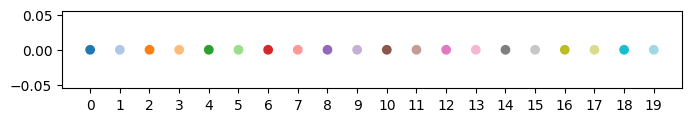

In [207]:
x = np.arange(20)
plt.scatter(x, np.full((len(x),),0),color=[mpl.cm.tab20(i) for i in x])
plt.xticks(np.arange(20))
plt.gcf().set_size_inches((8,1))

tma1_low_102


<Figure size 640x480 with 0 Axes>

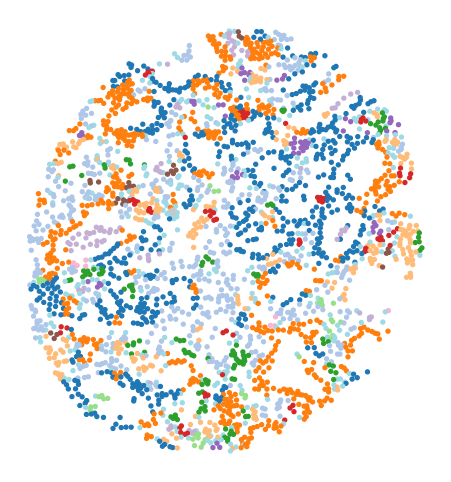

SCGP_annotation
 0     660
 2     630
 1     529
-1     328
 3     260
 4     129
 9      76
 6      74
 8      60
 5      38
 10     28
 13     10
 15      5
Name: count, dtype: int64


In [209]:
%%space lilab_tma
sample_name_vis = regions[1]
print(sample_name_vis)
obj_vis = ref_objs_map[sample_name_vis]
scgp.plot_all_regions_with_annotations(ref_scgp_partitions, obj_vis, figsize=6)
print(obj_vis.obs["SCGP_annotation"].value_counts())

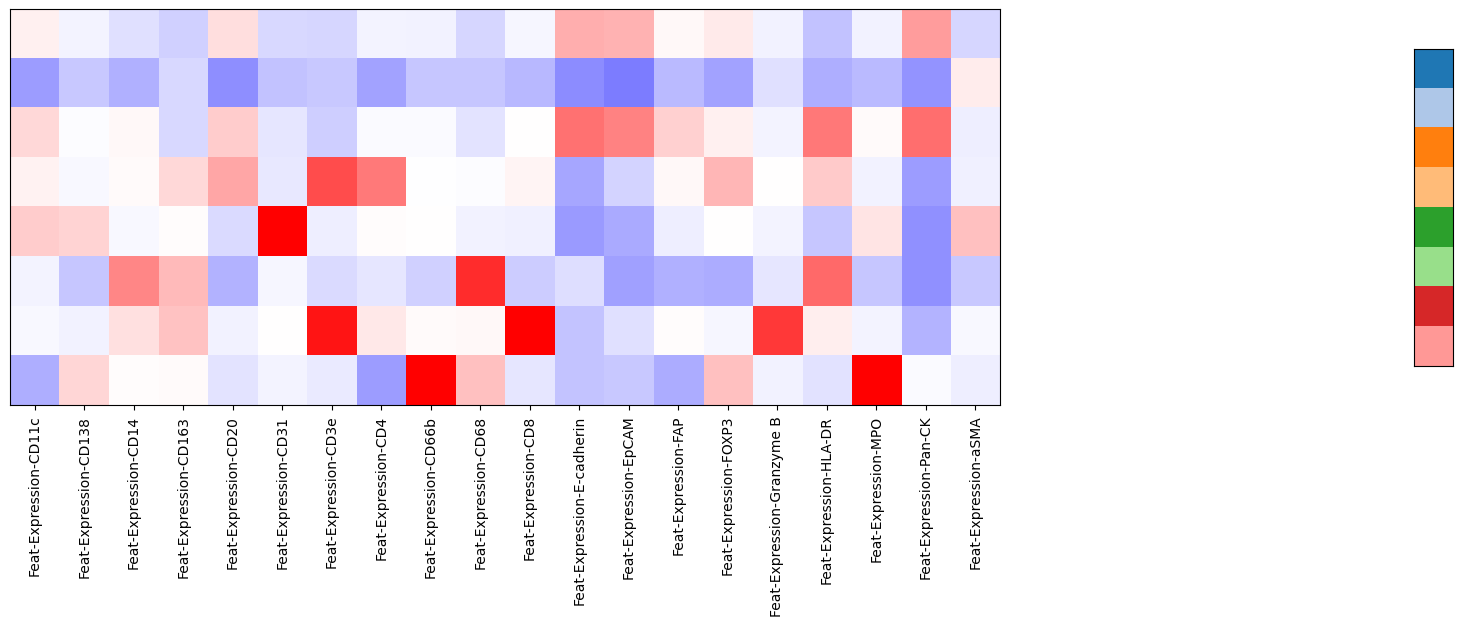

In [212]:
%%space lilab_tma
heatmap = scgp.plot_heatmap(ref_scgp_partitions, ref_objs, use_clusters=[0,1,2,3,4,5,6,7])
plt.gcf().set_size_inches((20,20))

In [172]:
%%space lilab_tma
# load query samples
all_samples = [fp.stem for fp in Path(adata_dir).glob("*.h5ad")]
core_samples = sorted(np.random.choice(all_samples,50,replace=False).tolist())
with open(os.path.join(project_dir,"external_data","scgp_core_samples.txt"),'w') as f:
    print("\n".join(core_samples),file = f)
    
query_samples = list(set(all_samples)-set(core_samples))[:10]
query_objs = list()

for sample_id in tqdm(query_samples):
    cell_seg_df = scgp.load_cell_coords(os.path.join(project_dir,"external_data","centroid",f'{sample_id}.HE.csv'))
    biomarker_expression_df = scgp.load_cell_biomarker_expression(os.path.join(project_dir,"external_data","expression_df",f'{sample_id}.csv'))
    
    obj = scgp.construct_object(
        sample_id, cell_seg_df, biomarker_expression_df,
        index_col='CELL_ID', mode='anndata'
    )  # mode can be 'emobject' or 'anndata', both will work for the following steps
    query_objs.append(obj)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 19.96it/s]


In [177]:
%%space lilab_tma
ref_dfs = scgp.make_pseudo_nodes(
    ref_objs, ref_scgp_partitions,
    # use_partitions=list(range(0,ref_partition_df["partition"].max()+1)), 
    use_partitions = [0,1,2,3,4,5,6],
    k=200, intra_knn=40
)

In [178]:
%%space lilab_tma
query_scgpext_partitions, (query_features, query_model) = scgp.SCGPExtension_wrapper(
    query_objs, ref_dfs,
    # using 3NN within query nodes (`intra_feature_knn`) and
    # the top `ratio` of 3NN between query nodes and reference pseudo-nodes (`inter_feature_knn`)
    intra_feature_knn=3, inter_feature_knn=3, ratio=0.5, 
    rp=1e-5, smooth_iter=1, smooth_level=1, seed = 456, verbose=True
)
Counter(query_scgpext_partitions.values())

Use 80716 spatial edges, 44032 feature edges, 41853 query-reference feature edges
Find 6 partitions
Featurization takes 7.31s, Clustering takes 7.45s


Counter({np.int64(4): 9272,
         np.int64(6): 6502,
         np.int64(0): 6271,
         np.int64(5): 4565,
         np.int64(3): 1028,
         np.int64(-1): 144,
         np.int64(1): 120})

In [179]:
%%space lilab_tma
query_partition_df = pd.DataFrame({
    "sample_id": [k[0] for k in query_scgpext_partitions.keys()],
    "cell_id": [k[1] for k in query_scgpext_partitions.keys()],
    "partition": [v for v in query_scgpext_partitions.values()]
})
query_objs_map = {obj.uns['name']:obj for obj in query_objs}
query_partition_df["partition"].value_counts()

partition
 4    9272
 6    6502
 0    6271
 5    4565
 3    1028
-1     144
 1     120
Name: count, dtype: int64

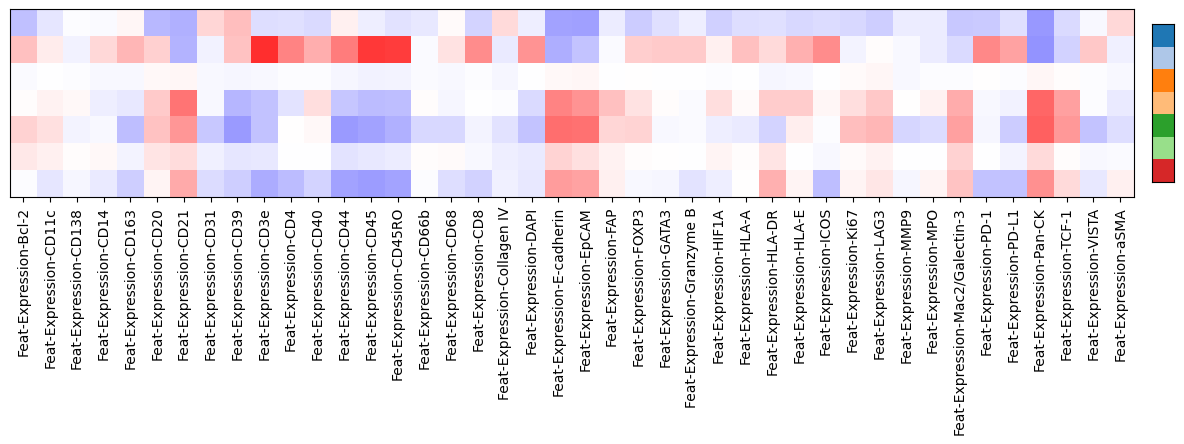

In [184]:
%%space lilab_tma
heatmap = scgp.plot_heatmap(ref_scgp_partitions, ref_objs, use_clusters=[0,1,2,3,4,5,6])
plt.gcf().set_size_inches((12,12))

<Figure size 640x480 with 0 Axes>

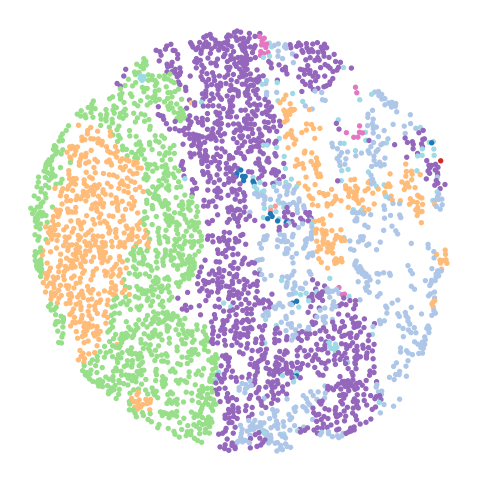

In [117]:
%%space lilab_tma
scgp.plot_all_regions_with_annotations(scgpext_partitions, query_objs[0:1], figsize=6)